In [1]:
# this is for stm32f3 masked aes implementation
# for STM32F3
SCOPETYPE='OPENADC'
PLATFORM='CW308_STM32F3'
CRYPTO_TARGET='TINYAES128C' 
SS_VER='SS_VER_1_1'

board = 'stm32f3'

In [2]:
# this is for xmega masked aes implementation
# for XMEGA
SCOPETYPE='OPENADC'
PLATFORM='CWLITEXMEGA'
CRYPTO_TARGET='TINYAES128C' 
SS_VER='SS_VER_1_1'

board = 'xmega'

In [3]:
%run jupyter/Setup_Scripts/Setup_Generic.ipynb

(ChipWhisperer NAEUSB WARNING|File naeusb.py:713) Your firmware (0.11) is outdated - latest is 0.64 See https://chipwhisperer.readthedocs.io/en/latest/firmware.html for more information


INFO: Found ChipWhisperer😍


In [4]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET" "$SS_VER"
cd hardware/victims/firmware/simpleserial-aes
make PLATFORM=$1 CRYPTO_TARGET=$2 SS_VER=$3 

Building for platform CWLITEXMEGA with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
Building for platform CWLITEXMEGA with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
make[1]: '.dep' is up to date.
Building for platform CWLITEXMEGA with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
.
Welcome to another exciting ChipWhisperer target build!!
avr-gcc (GCC) 5.4.0
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Compiling:
-en     simpleserial-aes.c ...
-e Done!
.
Compiling:
-en     .././simpleserial/simpleserial.c ...
-e Done!
.
Compiling:
-en     .././hal/xmega/XMEGA_AES_driver.c ...
-e Done!
.
Compiling:
-en     .././hal/xmega/uart.c ...
-e Done!
.
Compiling:
-en     .././hal/xmega/usart_driver

In [5]:
cmd = "hardware/victims/firmware/simpleserial-aes/simpleserial-aes-{}.hex".format(PLATFORM)
cw.program_target(scope, prog, cmd)
print(cmd)

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 4265 bytes
hardware/victims/firmware/simpleserial-aes/simpleserial-aes-CWLITEXMEGA.hex


In [6]:
from tqdm import tnrange
import numpy as np
import time

ktp = cw.ktp.Basic()
key, text = ktp.next()
target.set_key(key)

scope.adc.offset = 0
scope.adc.samples = 5000
ktp = cw.ktp.Basic()

In [7]:
# setup the key
dir(ktp)
aaa = ktp.getInitialKey()
#print(aaa)
bbb = ktp.getKeyType()
print(bbb)

#key_str = 'd2,d5,01,68,82,83,91,43,96,9e,e9,a2,53,a7,52,e1'
#key_str = 'e6,de,35,a9,a5,23,19,df,c6,cc,bb,ba,c1,36,c3,bf'
# #key_str = 'aa,80,d8,a7,84,d3,3f,5c,0b,90,a9,85,20,8e,ff,4a'
# ktp.fixed_key = False
# ktp.setInitialKey(key_str)
ktp.fixed_key = True
key, text = ktp.next()
print(key)

True
CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')


/home/ucsec/chipwhisperer/software/chipwhisperer/common/utils/util.py:497: UserWarning: getKeyType function is deprecated use get_key_type instead. This function will be removed in ChipWhisperer 5.7.0
  warnings.warn('{} function is deprecated use {} instead. This function will be removed in ChipWhisperer 5.7.0'.format(cc_func, func.__name__))


In [8]:
# run this when you want to change the key
target.set_key(key)
for i in range(3):
    key, text = ktp.next()
    print(key)
    print(text)
    print('==============')

CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')
CWbytearray(b'8c 28 9f b2 53 6c 16 3b f4 47 54 bc 11 5f 7f aa')
CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')
CWbytearray(b'60 7a 24 9f a5 98 3e 9b 23 f5 86 63 ca be 13 60')
CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')
CWbytearray(b'da 1c a0 08 9a 93 fb f8 74 6f 1d e3 b4 65 7a 42')


In [9]:
trace_array = []
textin_array = []
N = 10
for i in tnrange(N, desc='Capturing traces'):
    scope.arm()
    
    target.simpleserial_write('p', text)
    
    ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue
    
    response = target.simpleserial_read('r', 16)
    
    trace_array.append(scope.get_last_trace())
    textin_array.append(text)
    
    key, text = ktp.next() 

/tmp/ipykernel_53576/1577726309.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(N, desc='Capturing traces'):


Capturing traces:   0%|          | 0/10 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


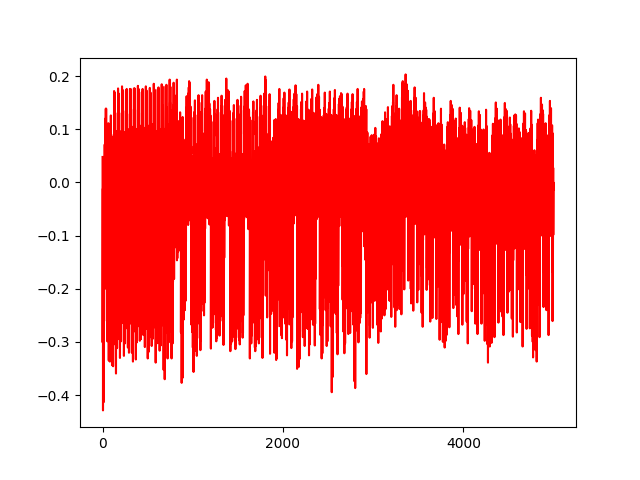

In [10]:
%matplotlib notebook
import matplotlib.pylab as plt
from matplotlib.pyplot import MultipleLocator

x_locator = MultipleLocator(2000)
ax = plt.gca()
ax.xaxis.set_major_locator(x_locator)

plt.plot(trace_array[2][0:5000], color='r')

In [11]:
scope

cwlite Device
sn         = 50203120324136503230343132333031
fw_version = 
    major = 0
    minor = 11
    debug = 0
gain = 
    mode = high
    gain = 30
    db   = 24.8359375
adc = 
    state          = False
    basic_mode     = rising_edge
    timeout        = 2
    offset         = 0
    presamples     = 0
    samples        = 5000
    decimate       = 1
    trig_count     = 43884
    fifo_fill_mode = normal
clock = 
    adc_src       = clkgen_x4
    adc_phase     = 0
    adc_freq      = 29538459
    adc_rate      = 29538459.0
    adc_locked    = True
    freq_ctr      = 0
    freq_ctr_src  = extclk
    clkgen_src    = system
    extclk_freq   = 10000000
    clkgen_mul    = 2
    clkgen_div    = 26
    clkgen_freq   = 7384615.384615385
    clkgen_locked = True
trigger = 
    triggers = tio4
    module   = basic
io = 
    tio1         = serial_rx
    tio2         = serial_tx
    tio3         = high_z
    tio4         = high_z
    pdid         = high_z
    pdic         = high_z
    

In [12]:
trace_array = []
textin_array = []
N = 300000
for i in tnrange(N, desc='Capturing traces'):
    scope.arm()
    
    target.simpleserial_write('p', text)
    
    ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue
    
    response = target.simpleserial_read('r', 16)
    
    trace_array.append(scope.get_last_trace())
    textin_array.append(text)
    
    key, text = ktp.next() 

/tmp/ipykernel_53576/747970629.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(N, desc='Capturing traces'):


Capturing traces:   0%|          | 0/300000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
%matplotlib notebook
import matplotlib.pylab as plt
from matplotlib.pyplot import MultipleLocator

x_locator = MultipleLocator(500)
ax = plt.gca()
ax.xaxis.set_major_locator(x_locator)

plt.plot(trace_array[2], color='r')

In [ ]:
# prepare the datas
import numpy as np
trace_array = np.float32(trace_array)
textin_array = np.float32(textin_array)
print(trace_array.shape)
print(textin_array.shape)
store_key = list(key)
store_key = np.array(store_key)
print(store_key.shape)
print(store_key)

if 'stm32f3' == board:
    attack_window = (1200,2200)
elif 'xmega' == board:
    attack_window = (1900, 4300)
    #attack_window = (1200, 9200)
else:
    raise
print('attack_window: ', attack_window)

In [13]:
# used to save the data
#os.makedirs(dataDir, exist_ok=True)
outpath='/home/ucsec/Desktop/X1_K1_150k_3.npz'
#outpath = os.path.join(dataDir, 'val_diff_key.npz')
np.savez(outpath, power_trace=trace_array[0:150000], plain_text=textin_array[0:150000],key=key)


In [ ]:
hex_key = [hex(val) for val in key]
print(hex_key)

In [ ]:
scope.dis()
target.dis()

In [17]:
len(trace_array)

150000

In [19]:
len(key)

16